In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import random as rnd
import pandas as pd
import math
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [13, 9]

Autosaving every 15 seconds


In [3]:
#Non-parametric regression
data = pd.read_csv("non-parametric.csv", delimiter=';')
data2 = [[k.x, k.y] for k in data.itertuples()]
xMin = data.x.min()
xMax = data.x.max()

In [4]:
def countMSE(fun, data):
    res = 0
    for [x, y] in data:
        res += (fun(x) - y) ** 2
    return res / len(data);


def buildFunc(fun, xMin, xMax, n):
    resX = []
    resY = []
    for i in np.linspace(xMin, xMax, n):
        resX.append(i)
        resY.append(fun(i))
    return (resX, resY)


In [34]:
#kernels
def uniform(x):
    return 0.5 if abs(x) < 1 else 0
def linear(x):
    return 1 - abs(x) if abs(x) < 1 else 0
def epanechnikov(x):
    return 0.75 * (1 - x ** 2) if abs(x) < 1 else 0
def gaussian(sigma):
    def res(x):
        return 1 / math.sqrt(2 * math.pi) * math.exp(- 1 / (2 * sigma ** 2) * (x ** 2))
    return res
def tricube(x):
    return 70. / 81. * (1 - abs(x) ** 3) ** 3 if abs(x) < 1 else 0
kernels = {"Uniform":uniform, "Linear":linear, "Epanechnikov":epanechnikov, 
           "Gaussian":gaussian(1), "Tricube":tricube}

In [6]:
#kernel smooth
def kernelSmooth(data, kernel, h):
    def res(pointX):
        p = 0
        q = 0
        for [x, y] in data:
            k = kernel(abs(pointX - x) / h)
            p += k * y
            q += k   
        if (q == 0):
            return 0
        else:
            return p / q
    return res

In [7]:
#local linear regression
def lowess(data, kernel, h, deg):
    def solver(pointX):     
        xi = [x for [x, y] in data]
        b1 = np.array([pointX ** i for i in range(deg + 1)])
        yi = np.array([y for [x, y] in data2])
        B = np.ones(len(data2))
        for i in range(1, deg + 1):
            t = np.array([x ** i for x in xi])
            B = np.vstack((B, t))
        B = B.T if deg > 0 else B.reshape((-1, 1))
        W = np.diag([kernel(abs(pointX - x) / h) for x in xi])
        res = np.linalg.inv(np.dot(np.dot(B.T, W), B))
        res = np.dot(b1, res)
        res = np.dot(np.dot(np.dot(res, B.T), W), yi)
        return res
    return solver

Linear MSE: 749.594828
Epanechnikov MSE: 800.547563
Gaussian MSE: 1002.781807
Tricube MSE: 771.067472
Uniform MSE: 864.332556


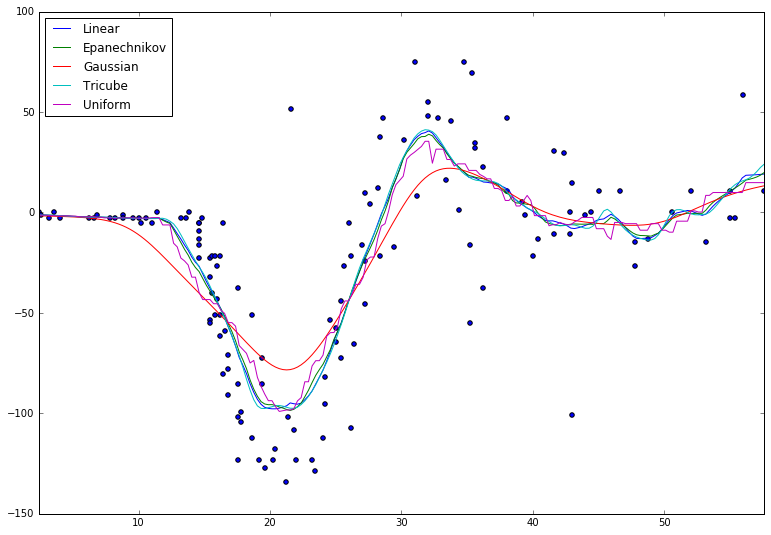

In [8]:
#smoothing, different kernels
for name, kernel in kernels.items():
    approx = kernelSmooth(data2, kernel, 3)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    plt.plot(resX, resY, label=name)
    print("{:s} MSE: {:f}".format(name, countMSE(approx, data2)))
plt.legend(loc=2)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.show()

Linear MSE: 767.030233
Epanechnikov MSE: 790.826232
Gaussian MSE: 1346.554057
Tricube MSE: 771.341967
Uniform MSE: 831.500171


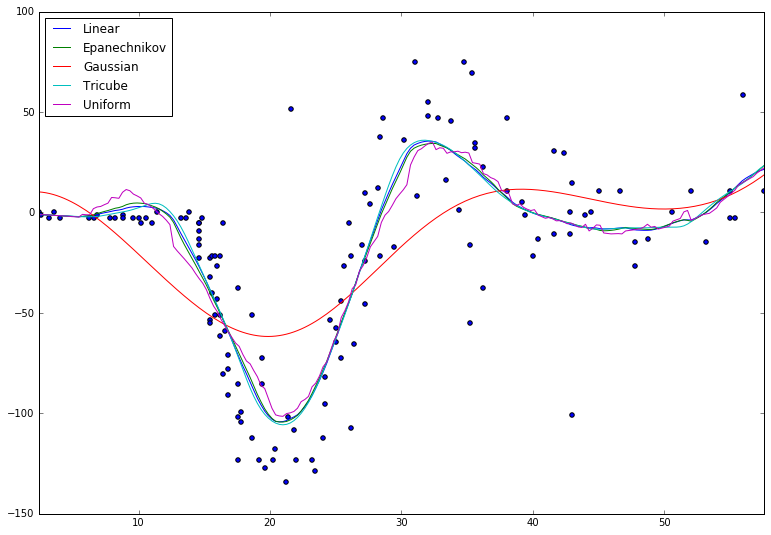

In [9]:
#local regression different kernels 
for name, kernel in kernels.items():
    approx = lowess(data2, kernel, 9, 2)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    plt.plot(resX, resY, label=name)
    print("{:s} MSE: {:f}".format(name, countMSE(approx, data2)))
plt.legend(loc=2)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.show()

polynom degree - 0 MSE: 2402.703218
polynom degree - 1 MSE: 2199.529403
polynom degree - 2 MSE: 2067.622859
polynom degree - 3 MSE: 1732.557489
polynom degree - 4 MSE: 1728.744283
polynom degree - 5 MSE: 1293.439720
polynom degree - 10 MSE: 765.402029


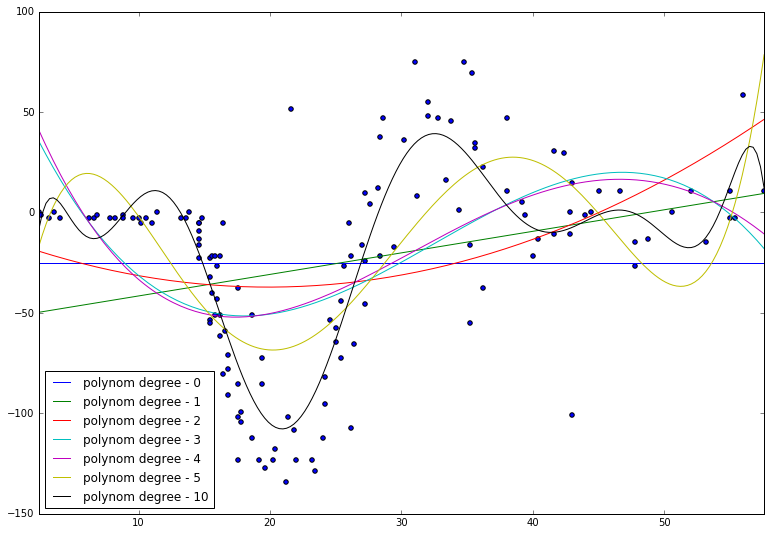

In [10]:
deg = [0, 1, 2, 3, 4, 5, 10]
for d in deg:
    approx = lowess(data2, uniform, 60, d)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    plt.plot(resX, resY, label="polynom degree - " + str(d))
    print("polynom degree - {:d} MSE: {:f}".format(d, countMSE(approx, data2)))
plt.legend(loc=3)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.show()

h = 2 MSE: 716.081549
h = 3 MSE: 758.585092
h = 5 MSE: 928.819654
h = 10 MSE: 1427.577020
h = 15 MSE: 1684.529997
h = 30 MSE: 1918.054685


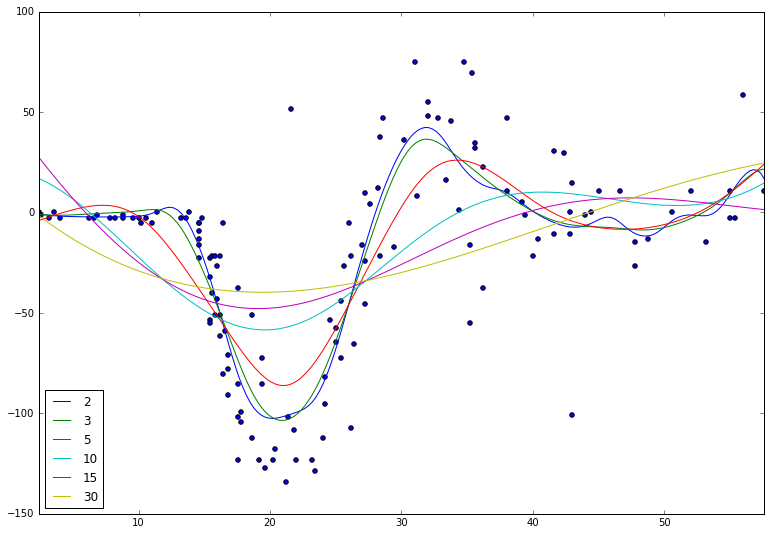

In [11]:
h = [2, 3, 5, 10, 15, 30]
for i in h:
    approx = lowess(data2, gaussian, i, 2)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    plt.plot(resX, resY, label=str(i))
    print("h = {:d} MSE: {:f}".format(i, countMSE(approx, data2)))
plt.legend(loc=3)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.show()

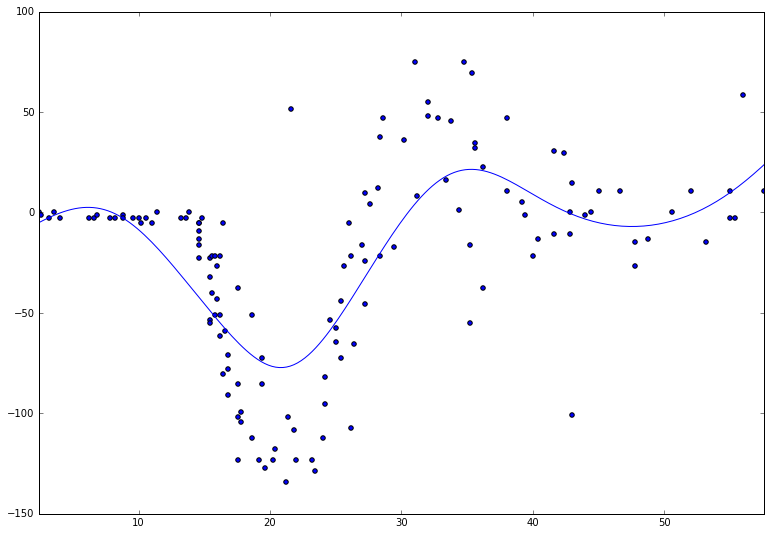

MSE: 1037.012634


In [12]:
approx = lowess(data2, gaussian, 6, 2)
(resX, resY) = buildFunc(approx, xMin, xMax, 200)
plt.scatter(data.x, data.y)
plt.plot(resX, resY)
plt.xlim(xMin, xMax)
plt.show()
print("MSE: {:f}".format(countMSE(approx, data2)))

MSE: 1004.988959
MSE: 1004.988959


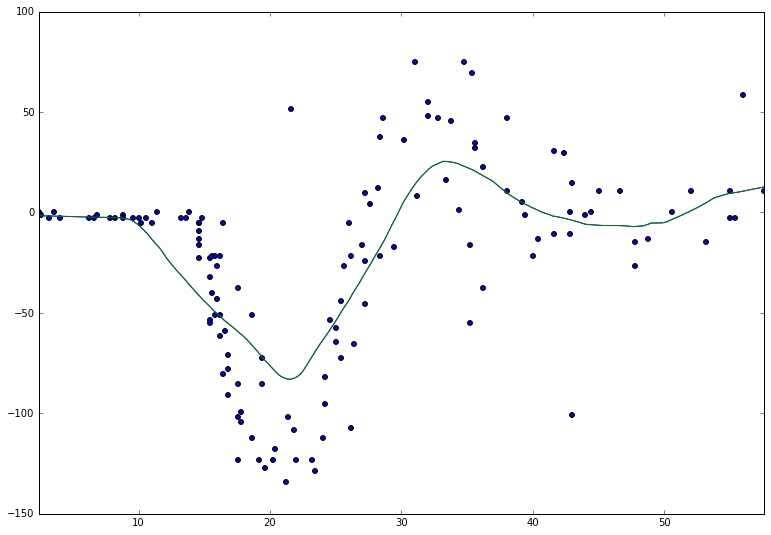

In [13]:
#check equality of 0 degree local regression and smothing
#loc
approx = lowess(data2, epanechnikov, 6, 0)
(resX, resY) = buildFunc(approx, xMin, xMax, 200)
plt.scatter(data.x, data.y)
plt.plot(resX, resY)
print("MSE: {:f}".format(countMSE(approx, data2)))

#smoothing
approx = kernelSmooth(data2, epanechnikov, 6)
(resX, resY) = buildFunc(approx, xMin, xMax, 200)
plt.scatter(data.x, data.y)
print("MSE: {:f}".format(countMSE(approx, data2)))
plt.plot(resX, resY)
plt.xlim(xMin, xMax)
plt.show()

kernel: Linear, degree: 0, window width: 4.000000 - MSE: 812.819627
kernel: Linear, degree: 0, window width: 5.000000 - MSE: 875.776734
kernel: Linear, degree: 0, window width: 7.000000 - MSE: 992.631877
kernel: Linear, degree: 0, window width: 10.000000 - MSE: 1183.072408
kernel: Linear, degree: 1, window width: 4.000000 - MSE: 731.317089
kernel: Linear, degree: 1, window width: 5.000000 - MSE: 765.662024
kernel: Linear, degree: 1, window width: 7.000000 - MSE: 869.266542
kernel: Linear, degree: 1, window width: 10.000000 - MSE: 1085.637357
kernel: Linear, degree: 2, window width: 4.000000 - MSE: 681.832888
kernel: Linear, degree: 2, window width: 5.000000 - MSE: 703.162296
kernel: Linear, degree: 2, window width: 7.000000 - MSE: 730.737553
kernel: Linear, degree: 2, window width: 10.000000 - MSE: 790.918498
kernel: Linear, degree: 3, window width: 4.000000 - MSE: 672.904465
kernel: Linear, degree: 3, window width: 5.000000 - MSE: 695.921366
kernel: Linear, degree: 3, window width: 7.

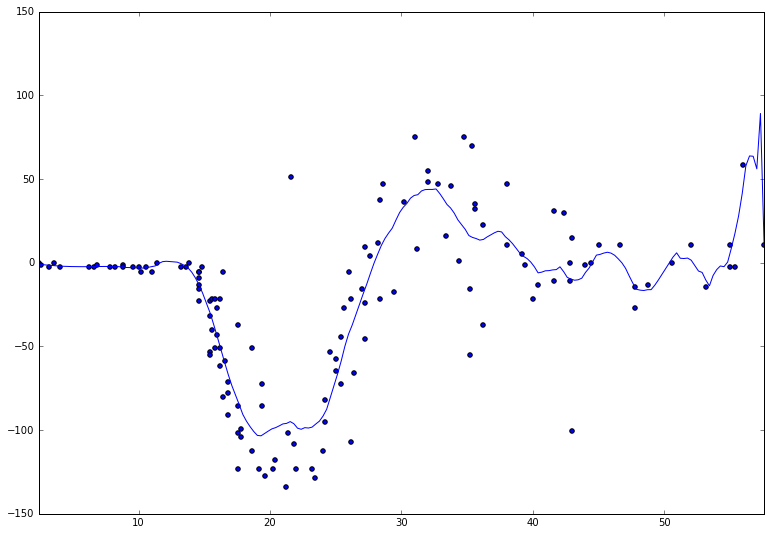

In [22]:
deg = [0, 1, 2, 3]
windowWidth = [4, 5, 7, 10]
bestMSE = 1e+7
for name, kern in kernels.items():
    for d in deg:
        for h in windowWidth:
            approx = lowess(data2, kern, h, d)
            mse = countMSE(approx, data2)
            print("kernel: {:s}, degree: {:d}, window width: {:f} - MSE: {:f}".format(name, d, h, mse))
            if bestMSE > mse:
                bestMSE = mse
                bestKernel = name
                bestDegree = d
                bestWidth = h
print("====Result=====")
print("kernel: {:s}, degree: {:d}, window width: {:f} - MSE: {:f}".
      format(bestKernel, bestDegree, bestWidth, bestMSE))
approx = lowess(data2, kernels[bestKernel], bestWidth, bestDegree)
(resX, resY) = buildFunc(approx, xMin, xMax, 200)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.plot(resX, resY)
plt.show()

In [25]:
fixedMSE = 1000
l = 3
r = 15
while (r - l > 1e-5):
    m = (r + l) / 2
    approx = lowess(data2, gaussian, m, 2)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    mse = countMSE(approx, data2)
    if (mse >= fixedMSE):
        r = m
    else:
        l = m
    print("h = {:f} MSE: {:f}".format(m, mse))
print(r)

h = 9.000000 MSE: 1346.554057
h = 6.000000 MSE: 1037.012634
h = 4.500000 MSE: 877.666313
h = 5.250000 MSE: 955.299958
h = 5.625000 MSE: 995.804379
h = 5.812500 MSE: 1016.337718
h = 5.718750 MSE: 1006.051000
h = 5.671875 MSE: 1000.922407
h = 5.648438 MSE: 998.362040
h = 5.660156 MSE: 999.641889
h = 5.666016 MSE: 1000.282065
h = 5.663086 MSE: 999.961956
h = 5.664551 MSE: 1000.122006
h = 5.663818 MSE: 1000.041980
h = 5.663452 MSE: 1000.001968
h = 5.663269 MSE: 999.981962
h = 5.663361 MSE: 999.991965
h = 5.663406 MSE: 999.996966
h = 5.663429 MSE: 999.999467
h = 5.663441 MSE: 1000.000717
h = 5.663435 MSE: 1000.000092
5.663434982299805


h = 0.100000 MSE: 564.373740
h = 0.500000 MSE: 758.585092
h = 1.000000 MSE: 1037.012634
h = 2.000000 MSE: 1556.742488
h = 5.000000 MSE: 1918.054685
h = 10.000000 MSE: 2024.739766
h = 15.000000 MSE: 2048.124803


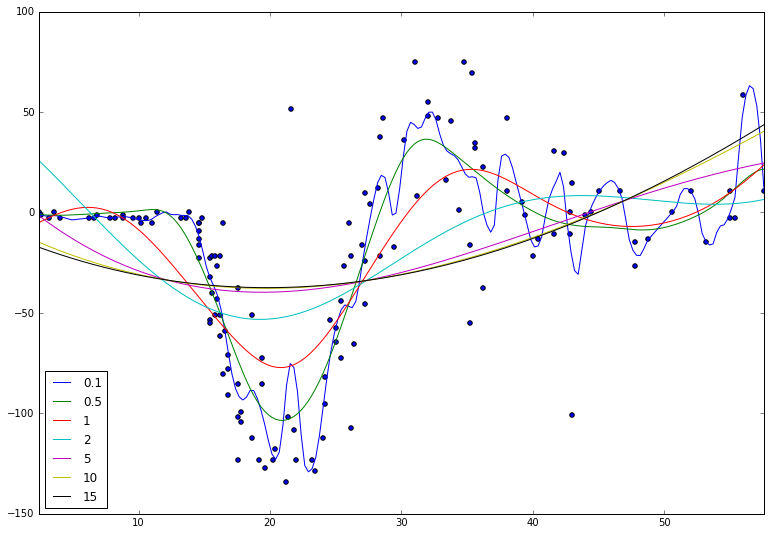

In [40]:
sigma = [0.1, 0.5, 1, 2, 5, 10, 15]
for i in sigma:
    approx = lowess(data2, gaussian(i), 6, 2)
    (resX, resY) = buildFunc(approx, xMin, xMax, 200)
    plt.plot(resX, resY, label=str(i))
    print("h = {:f} MSE: {:f}".format(i, countMSE(approx, data2)))
plt.legend(loc=3)
plt.scatter(data.x, data.y)
plt.xlim(xMin, xMax)
plt.show()

In [41]:
h = [3, 4, 5, 9, 10, 15]
for name, kernel in kernels.items():
    for i in h:
        approx = kernelSmooth(data2, kernel, i)
        (resX, resY) = buildFunc(approx, xMin, xMax, 200)
        print("kernel: " + name + ", h = {:d} MSE: {:f}".format(i, countMSE(approx, data2)))

kernel: Linear, h = 3 MSE: 749.594828
kernel: Linear, h = 4 MSE: 812.819627
kernel: Linear, h = 5 MSE: 875.776734
kernel: Linear, h = 9 MSE: 1113.027939
kernel: Linear, h = 10 MSE: 1183.072408
kernel: Linear, h = 15 MSE: 1534.304801
kernel: Epanechnikov, h = 3 MSE: 800.547563
kernel: Epanechnikov, h = 4 MSE: 866.028588
kernel: Epanechnikov, h = 5 MSE: 935.958064
kernel: Epanechnikov, h = 9 MSE: 1205.503806
kernel: Epanechnikov, h = 10 MSE: 1291.047859
kernel: Epanechnikov, h = 15 MSE: 1713.377890
kernel: Gaussian, h = 3 MSE: 1002.781807
kernel: Gaussian, h = 4 MSE: 1149.230944
kernel: Gaussian, h = 5 MSE: 1303.087534
kernel: Gaussian, h = 9 MSE: 1813.522380
kernel: Gaussian, h = 10 MSE: 1895.085122
kernel: Gaussian, h = 15 MSE: 2127.104528
kernel: Tricube, h = 3 MSE: 771.067472
kernel: Tricube, h = 4 MSE: 829.434338
kernel: Tricube, h = 5 MSE: 885.324546
kernel: Tricube, h = 9 MSE: 1108.313203
kernel: Tricube, h = 10 MSE: 1168.696372
kernel: Tricube, h = 15 MSE: 1524.950805
kernel: Uni